# Synthetic dataset for  marine streamer setup

Generation of synthetic data for training is tailored around the field dataset. All public specifications of the dataset are stored in `Survey` object which then defines dimensions of generated models. The survey also contains sources and receivers that approximate the 2D field setup.


In this notebook we generate and compare:

* Random subsurface models
* Acoustic data
* **Elastic data** (used in this study)

------
This notebook reproduces the workflow for an experiment from 
**"Multi-task learning for low-frequency extrapolation and elastic model building from seismic data"**

by [Ovcharenko Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://vkazei.com/), [Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Daniel Peter](https://github.com/danielpeter), KAUST, Saudi Arabia, 2021

In [1]:
import os
import re
import sys
import time
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import multiprocessing.pool

import segyio

from scipy.ndimage.filters import gaussian_filter

from scipy import signal
from natsort import natsorted
import seaborn as sns

import utils.mgen as mgen
import utils.datasetmaker as datasetmaker
import utils.shared as sd
import utils.loaders as ld
import utils.vis as vis
from utils.shared import Survey

from IPython.display import clear_output

# ----------------------------------
# Point to the Python API for Denise-Black-Edition
# This is typically shipped with the main code
# https://github.com/daniel-koehn/DENISE-Black-Edition
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api

In [2]:
print(f'Python is from this environment: {sys.prefix}')

Python is from this environment: /home/ovcharoo/work/env_torch


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 100,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

## Default paths in the local folder

In [4]:
# Where to store datasets
root_out = './pretrained_files/data/'

In [5]:
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

# Init Denise API

In [6]:
# Point to the folder with compiled DENISE-Black-Edition!
denise_root = './DENISE-Black-Edition-master/'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../den/bin/denise
Parse ../den/par/DENISE_marm_OBC.inp
Current directory is /home/ovcharoo/work/mtl_low
Init paths at ./outputs/


# Init modeling configs

Load specs of seismic survey

In [7]:
survey = sd.load_obj('./pretrained_files/data/survey.pkl')

src = survey.src # sources object
rec = survey.rec # receivers object
vp = survey.vp # empty np.ndarray for velocity model
dx = survey.dx # grid spacing
wb_taper = survey.wb_taper # empty np.ndarray for water taper
log_idx = survey.log_idx # grid node idx with well-log location
log_loc = survey.log_loc # absolute location of the well-log (meters)
bpw = survey.bpw # source wavelet
dDT = survey.dDT # time sampling of field seismograms
dNT = survey.dNT # number of time steps in field seismograms

Load obj from ./pretrained_files/data/survey.pkl


In [8]:
dsrc = np.mean(src.x[1:] - src.x[:-1])
print('Field data spacing between sources {:.2f} m'.format(dsrc))

Field data spacing between sources 150.00 m


## Acquisition design

In [9]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wls[:, :dNT]

In [10]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -5.2003522040678645	max: 6.286853676317875
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [11]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = dNT
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


# Generation of synthetic dataset

In the following we first generate a set of random subsurface models. Then we run acoustic wave propagation, followed by elastic wave propagation in the same set of subsurface models. Finally, we compare acoustic and elastic approximations of seismic waves. 

All deep learning examples use **elastic data only**.

## Acoustic training dataset

In [12]:
# This is where RAW wavefields will be saved. If you later uncomment the modeling
# part, make sure that you are good with saving ~5 Gb of data in that location
#
# (GENERATION OF RAW DATA IS DISABLED BY DEFAULT)
root_raw_ac = './pretrained_files/data/raw/syn_1024_ac/'

# Where to store processed dataset (not yet the training one)
root_dataset_syn = os.path.join(root_out, 'syn_1024_ac')
path_save_rand_models = os.path.join(root_raw_ac, 'rand_models.npy')

In [13]:
nmodels = 1024 # Number of random subsurface models
box_min = 1490. # minimum velocity in the dataset (water)
box_max = 4000. # maximum velocity in the dataset (this might have been higher, but I chose this one)

In [14]:
vp_init = vp[:, :500]
nz, nx = vp_init.shape
print(vp_init.shape, vp_init.min(), vp_init.max(), nz, nx)

(152, 500) 0.0 0.0 152 500


### Background trend

In [15]:
def make_init(m_like):
    """Generate a pseudo-random background trend
    Args:
        m_like(np.ndarray): [nz, nx] the donor of shape for background model 
    """
    log = m_like[:, 0:1]
    vps = []
    # Range of randomization of flat water bottom.
    # Here, it varies from 25 to 45 grid points (25 m spacing).
    # Note, the final layered model is distorted by elastic tranformation, so 
    # these boundaries of water bottom are very approximate
    wb = 35 + np.random.randint(-10, 10)
    
    # Empiric "average" trend in the middle of box constraints, might be made in a smarter way
    slope = 8 + np.random.randint(-4, 4)
    
    # This loop goes over each grid node in OX direction and created a 1D velocity profile.
    # In this case all these profiles are identical, but the loop is legacy from implementation with
    # variable water depth.
    for i in range(nx):
        fun = box_min * np.ones_like(log)
        fun[wb:, :] = 575 + fun[wb:, :] + slope * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
        fun = fun[::-1, :]
        vps.append(fun)
    return np.concatenate(vps, -1)

print(vp_init.shape)

(152, 500)


### Random velocity models

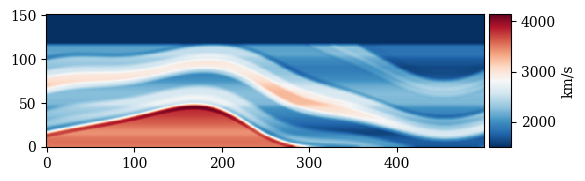

In [16]:
def get_model(nz, nx):
    model = mgen.get_2d_layered_model(nz, nx)
    # These are empirical constants for distortion, which work well for given problem size.
    alpha_x = 1e3 + 1e3 * np.random.rand()
    alpha_z = 2e4 + 1e4 * np.random.rand()
    sigma_x = 20 + 80 * np.random.rand()
    sigma_z = 50 + 30 * np.random.rand()
    model_ = mgen.elastic_transform(model, alpha_x, alpha_z, sigma_x, sigma_z, mode='nearest')
    
    # Map the generated model into the specified range of velocities
    geo = mgen.GeologyScaler(model_, [1400, 3000 + 3000 * np.random.rand()])
    model_ = geo.g2r(model_)
    model_ = np.flipud(model_[..., 0])
    
    # Subtract existing 1D background model
    model_ -= np.repeat(np.expand_dims(np.mean(model_, -1), 1), nx, axis=-1)
    
    # Add the 1D background model sampled around the desired one
    new_init = make_init(vp_init)
    model_ += new_init
    
    # Substitute the water bottom from sampled background model
    mask = new_init == np.min(new_init)
    model_[mask] = new_init[mask]

    # Smooth a bit to get rid of seafloor transition
    s, w = 2, 5
    sigma_truncate = {'sigma': s, 'truncate': (((w - 1)/2)-0.5)/s}
    model_ = gaussian_filter(model_, **sigma_truncate)
    return model_

# Voila. Press `Ctrl + Enter` to see more random models
vis.plot_model(get_model(nz, nx))

### Parallel generation of random subsurface models

Generate a set of random subsurface models and save the to the same folder where raw data should be stored.

In [17]:
def _get_model(imodel, nz, nx):
    model = get_model(nz, nx)
    return model

if not os.path.exists(path_save_rand_models):
    num_cores = multiprocessing.cpu_count() // 2

    print('Start parallel pool for model generation...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_cores) as pool:
        other_models = pool.starmap(_get_model, zip(model_ids, 
                                                   itertools.repeat(nz), 
                                                   itertools.repeat(nx)))
    print(f'OK, {time.time() - t1} sec')
else:
    print(f'Load random models from {path_save_rand_models}...', end='')
    loaded = np.load(path_save_rand_models)
    other_models = [loaded[i, ...] for i in range(loaded.shape[0])]
    print(len(other_models), other_models[0].shape)

Load random models from ./pretrained_files/data/raw/syn_1024_ac/rand_models.npy...1024 (152, 500)


Apply box constraints to the set of generated models

In [18]:
par_box = {'vmin': box_min, 'vmax': box_max}
par_box_km = {'vmin': box_min / 1000, 'vmax': box_max / 1000}
print(f'Apply box conditions to {len(other_models)} models of shape {other_models[0].shape}')
for imodel in range(len(other_models)):
    other_models[imodel][other_models[imodel] < box_min] = box_min
    other_models[imodel][other_models[imodel] > box_max] = box_max

Apply box conditions to 1024 models of shape (152, 500)


### Visualize the dataset of models

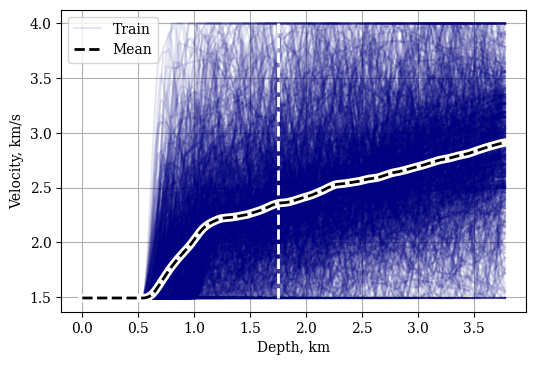

In [19]:
log_idx = int(log_loc / dx)
true_log = vp[::-1, log_idx] / 1000
xax = dx * np.arange(len(true_log)) / 1000
mean_log = []
for imodel in range(nmodels-1):
    log = other_models[imodel][::-1, log_idx] / 1000
    mean_log.append(log)
    plt.plot(xax, log, 'navy', alpha=0.1)
log = other_models[nmodels-1][::-1, log_idx] / 1000
plt.plot(xax, log, 'navy', alpha=0.1, label='Train')

mean_log = sum(mean_log) / len(mean_log)
# Vertical profile
loc_dist = 1.75
idx_dist = int(loc_dist * 1000 / dx)
plt.plot(np.ones_like(xax) * loc_dist, 
         box_min/1000 + np.linspace(0, 1, len(xax)) * (box_max - box_min)/1000, 
         'w--', lw=2)

# Mean profile
plt.plot(xax, mean_log, 'w', lw=6)
plt.plot(xax, mean_log, 'k--', lw=2, label='Mean')
plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s'); 
plt.grid(True)
plt.legend();
# vis.savefig('vlogs.png')

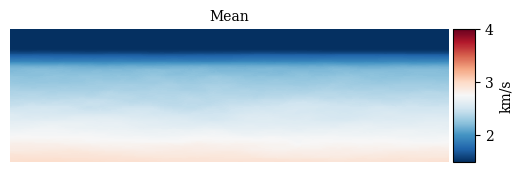

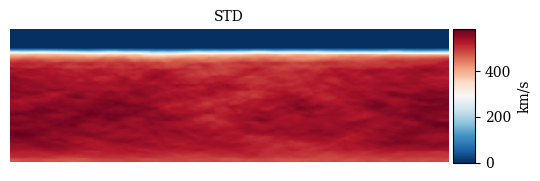

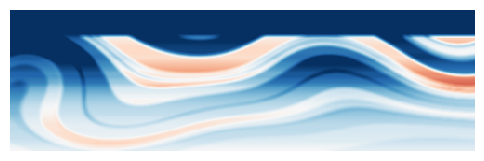

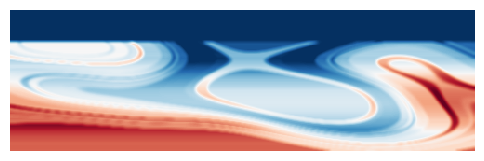

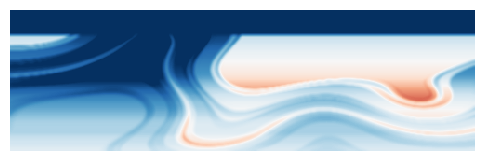

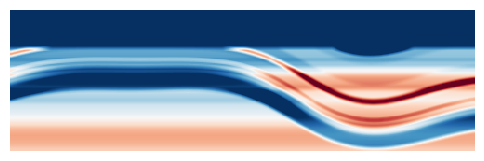

In [20]:
# Plot mean and std throughout dataset
vis.plot_model(np.mean(other_models, 0) / 1000, title='Mean', axis='off', cax_label='km/s', **par_box_km)
vis.plot_model(np.std(other_models, 0), title='STD', axis='off')

# Plot a few samples from the dataset
for i in [int(np.floor(x)) for x in np.linspace(0, nmodels-1, 4)]:
    vis.plot_model(other_models[i], axis='off', colorbar=False, **par_box)

In [21]:
# Create volume of models from the list of models
vol = np.concatenate([np.expand_dims(m, 0) for m in other_models], 0)
print(vol.shape)

(1024, 152, 500)


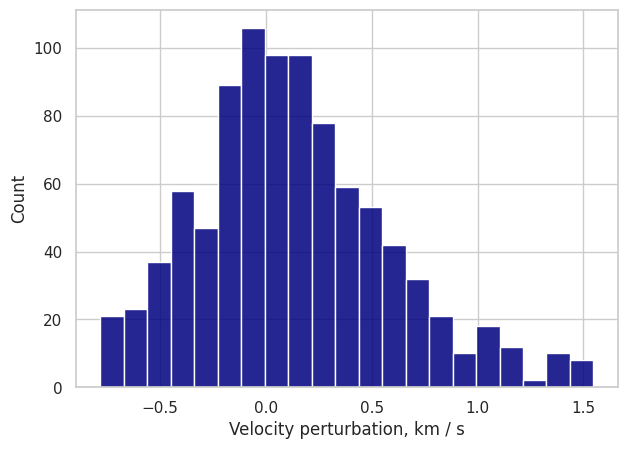

In [22]:
# Plot histogram at particular log location
the_log = (vol - np.mean(vol, keepdims=True))[:, :, idx_dist] / 1000
dist = the_log[:, the_log.shape[-1] // 2]

# Actual plotting
sns.set(style='whitegrid', palette="Blues_r", rc={"figure.figsize": [7, 5]})
sns.histplot(dist, kde=False, stat='count', color = 'navy', alpha = 0.85,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(0.99 * np.min(dist), 0.9 * np.max(dist)),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count');

## Prepare forward modeling

We simulate 3 shots in each of subsurface models

In [23]:
rec_syn = copy.deepcopy(rec) # Copy field config of receivers
xsrc0 = src.x[0]  # select first shot location same as in field data
dsrc_syn = 1000.  # spacing between sources (might be larger, only need to fit streamer into the model)
_nsrc = 3         # number of sources to simulate
xsrc = xsrc0 + np.arange(_nsrc) * dsrc_syn        # locations of all sources
ysrc = np.array([src.y[0] for _ in range(_nsrc)]) # Depth similar to the one of field data

# ACOUSTIC! Note, there is a bug somewhere in C code for acoustic modeling
# so we need to reverse polarity of the source wavelet
src_syn_ac = api.Sources(xsrc, ysrc)
wls = bpw[:len(src_syn_ac), ::2]
src_syn_ac.wavelets = -wls[:, :dNT] # set the same wavelet for all sources
print(src_syn_ac)
print(rec_syn)

name:	
x	(3,):	min: 1125.0	max: 3125.0
y	(3,):	min: 50.0	max: 50.0
wavelets	(3, 3000):	min: -6.286853676317875	max: 5.2003522040678645
z	(3,):	min: 0.0	max: 0.0
nshot:	3
td	(3,):	min: 0.0	max: 0.0
fc	(3,):	min: 8.0	max: 8.0
amp	(3,):	min: 1.0	max: 1.0
angle	(3,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(3,):	min: 1.0	max: 1.0
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [24]:
# Run forward modeling a little bit longer than 3000 time steps
# to crop off it later after band-pass filtering
ext_nt = 100

In [25]:
# Init Denise for syn data generation
d_syn = copy.deepcopy(d)

d_syn.verbose = 1 # Print out necessary info

d_syn.DT = dDT # time sampling
d_syn.NT = d.NT + ext_nt # number of time steps
d_syn.TIME = dDT * d_syn.NT # recording length, seconds
d_syn.N_STREAMER = len(rec_syn[0]) # how many hydrophones are in the streamer
d_syn.REC_INCR_X = dsrc_syn # how much to move streamer for every shot

d_syn.PHYSICS = 2 # Acoustic modeling

d_syn.NPROCX = 4 # Domain partitioning along OX for MPI
d_syn.NPROCY = 1 # Domain partitioning along OZ for MPI

print(d_syn.NT, d_syn.DT)

3100 0.002


152 500


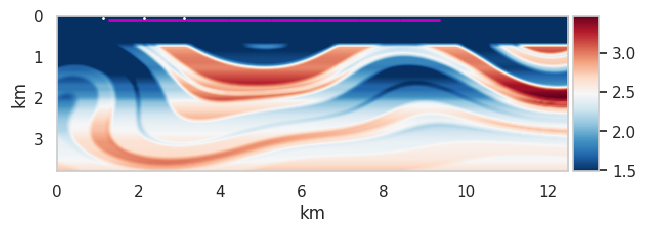

In [26]:
def make_vp_vs_rho(vp):
    """Gardner's relations and 
    https://www.subsurfwiki.org/wiki/Gardner%27s_equation
    """
    vs = vp.copy() / (3 ** 0.5)     # S-wave velocity from P-wave velocity
    taper = vp < 1.01 * np.min(vp)     # Where is water?
    vs = np.where(taper, 0, vs)  # Set S-waves to zero in water
    rho = 1e3*0.3 * vp.copy()**0.25 # Gardner's equation for density, kg/m3
    rho = np.where(taper, 1000, rho) # Set density of water in water
    return vp, vs, rho

# Sample initialization of elastic random subsurface model
model_syn = api.Model(*make_vp_vs_rho(other_models[0]), dx)
print(model_syn.nz, model_syn.nx)
mpl.rcParams['axes.grid']= False
vis.plot_acquisition(model_syn.vp, dx, src_syn_ac, rec_syn)

## Start modeling acoustic data
We parallelize forward modeling over computational domain and generated subsurface models. Earlier we specified domain parallelization on 4 cores (4 OX x 1 OZ). There are 48 cores in my machine so I can afford modeling in 12 subsurface models at the same time.

**Change the value below** to match the number of cores on your maching.

In [27]:
num_simultaneous_runs = 12 # <<YOUR NUMBER OF CORES>> / 4

-----
**Unomment below to run HEAVY forward modeling**

In [28]:
# def _run_model(im, m, dx, path_output, src_this, run_command):
#     _d_syn = copy.deepcopy(d_syn)
#     _d_syn.verbose = 0 # don't print out 
#     d_syn.QUELLART = 3 # use custom wavelet
#     _d_syn.save_folder = os.path.join(path_output, f'model_{im}/') # where to save raw data
#     os.makedirs(_d_syn.save_folder, exist_ok=True) 
    
#     vp, vs, rho = make_vp_vs_rho(m) # Create vp, vs, rho from vp
#     model_syn = api.Model(vp, vs, rho, dx)
#     clear_output() # clean previous outputs
    
#     # Run modeling
#     _d_syn.forward(model_syn, src_this, rec_syn, run_command)
#     return None

# if not os.path.exists(os.path.join(root_raw_ac, 'su/')):
#     print('Start parallel pool for modeling...', end='')
#     model_ids = [i for i in range(nmodels)]
#     t1 = time.time()
#     with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
#         tmp = pool.starmap(_run_model, zip(model_ids, other_models, 
#                                            itertools.repeat(dx), 
#                                            itertools.repeat(root_raw_ac),
#                                            itertools.repeat(src_syn_ac),
#                                            itertools.repeat('mpirun -np 4')))
#         print(f'OK, {time.time() - t1} sec')
# else:
#     print(f'Data are already in {root_raw_ac}')

## Save random models
Save the set of generated models to reach some level of reproducibility

In [29]:
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_raw_ac, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))
else:
    print(f'Models are already in {path_save_rand_models}')

Models are already in ./pretrained_files/data/raw/syn_1024_ac/rand_models.npy


## Process raw data

The forward modeling defined above creates a folder with 3 shot gathers `.su` for each of the subsurface models. We peel off the model layer of folders, band-pass the data < 15 Hz and change format of each shot to Madagascar's `.hh`. Note, **this is not yet training dataset**.

In [30]:
_path_syn_dataset = os.path.join(root_dataset_syn, 'train/raw/')
os.makedirs(_path_syn_dataset, exist_ok=True)
print(f'Prepare to save the processed dataset into {_path_syn_dataset}')

Prepare to save the processed dataset into ./pretrained_files/data/syn_1024_ac/train/raw/


In [34]:
par_split = {}
par_split['format'] = '.hh'
par_split['dir_dataset'] = root_dataset_syn
par_split['dir_syn'] = root_raw_ac
par_split['partitions'] = [90, 5, 5]
par_split['split_from_files'] = False
par_split['split_hh'] = False
par_split['file_keys'] = ['.su']
par_split['from_files'] = False
par_split['jump_files'] = 1
par_split['rules'] = {'raw': 'sfbandpass fhi=15 | sfwindow j1=1'}
par_split['jump_folders'] = 1
par_split['delete_old'] = False
par_split['pre'] = 'sfsuread endian=n su=y |'
par_split['post'] = ' '


if ld.is_empty(_path_syn_dataset):
    maker = datasetmaker.DatasetMaker(par_split, verbose=1)
    maker.run()
    print(f'Check syn dataset in {_path_syn_dataset}')
else:
    print(f'Data are already in {_path_syn_dataset}')

SynSplit
From 1025 folders in ./pretrained_files/data/raw/syn_1024_ac/
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_0/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_1/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_2/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_3/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_4/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_5/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_6/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_7/su. Delete old=False!
There are 3 files with ['.su'] in ./pretrained_files/data/raw/syn_1024_ac/model_8/su. Delete old=

### Init loader for visualization

In [35]:
par_loader={'crop': (None, None), 'skip': (1,1), 'norm': True}

print(_path_syn_dataset)
fnames_ac = ld.parse_files(_path_syn_dataset, '*.hh')
loader_src_tr_ac = ld.Loader(fnames_ac, par_loader)

./pretrained_files/data/syn_1024_ac/train/raw/
Found 2765 files in ./pretrained_files/data/syn_1024_ac/train/raw/:
	./pretrained_files/data/syn_1024_ac/train/raw/model_0_seis_p.shot2.hh
	./pretrained_files/data/syn_1024_ac/train/raw/model_1023_seis_p.shot3.hh


In [36]:
index = 2 # sample index
print(f'Init loader for:\t{_path_syn_dataset}')
dat = loader_src_tr_ac.__getitem__(index)
print('Each data sample contains:\n\tdata: {}\n\tfilename: {}'.format(dat[0].shape, dat[1]))

Init loader for:	./pretrained_files/data/syn_1024_ac/train/raw/
Each data sample contains:
	data: (324, 3100)
	filename: ./pretrained_files/data/syn_1024_ac/train/raw/model_1_seis_p.shot1.hh


In [37]:
def valinfo(v):
    return v.shape, v.min(), v.max()
    
dat_src = dat[0]
print(f'File name: {dat[1]}\nValue: {valinfo(dat_src)}')

File name: ./pretrained_files/data/syn_1024_ac/train/raw/model_1_seis_p.shot1.hh
Value: ((324, 3100), -0.7488092, 1.0)


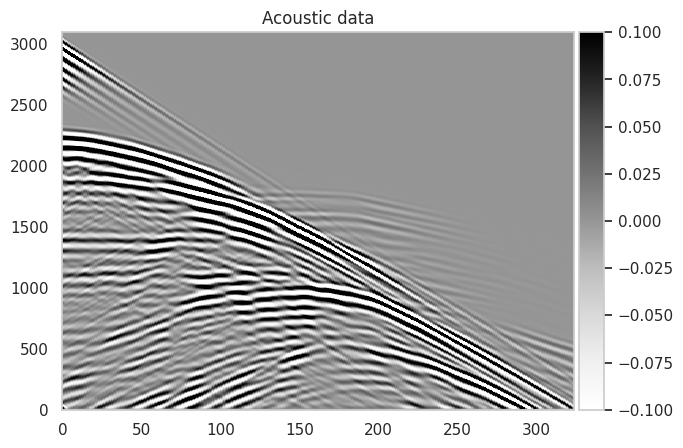

In [38]:
vis.plot_shot(dat_src, 0.1, title='Acoustic data')

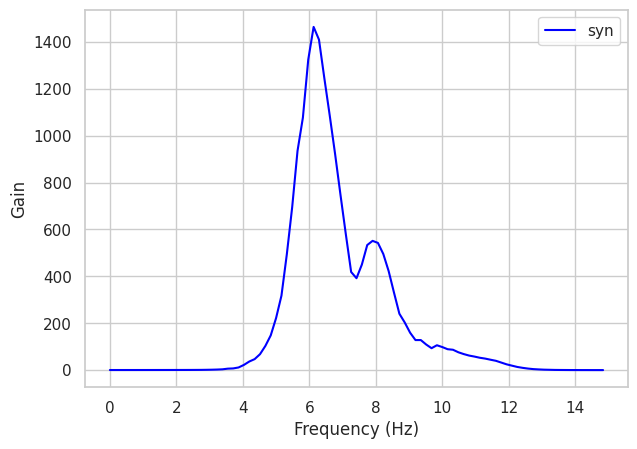

In [39]:
vis.plot_spectra_dict([{'syn': dat_src}], d.DT, 15, labels=['', '', ''], norm=False)

### Statistics

In [40]:
# Mean train dataset
def get_loader_stats(loader, dat_shape):
    n_src_tr = len(loader)
    dat_src_tr = np.zeros((n_src_tr, *dat_shape))
    for i in range(n_src_tr):
        print(f'{i+1}/{n_src_tr}', end='\r')
        dat = loader.__getitem__(i)[0]
        if np.isnan(dat).any():
            dat = 0.
            print('NaN caught!')
        dat_src_tr[i,...] = dat
        
    src_tr_mean = np.mean(dat_src_tr, 0)
    src_tr_std = np.std(dat_src_tr, 0)
    return src_tr_mean, src_tr_std

path_src_tr_mean = os.path.join(root_dataset_syn, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean_ac, src_tr_std_ac = get_loader_stats(loader_src_tr_ac, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean_ac)
    np.save(path_src_tr_std, src_tr_std_ac)
else:
    print(f'Load mean and std from {path_src_tr_mean}')
    src_tr_mean_ac = np.load(path_src_tr_mean)
    src_tr_std_ac = np.load(path_src_tr_std)

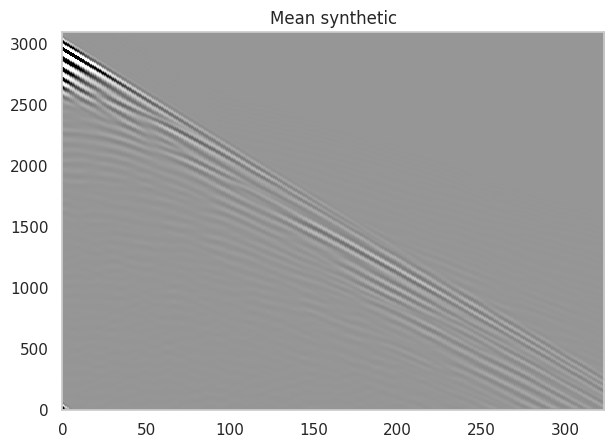

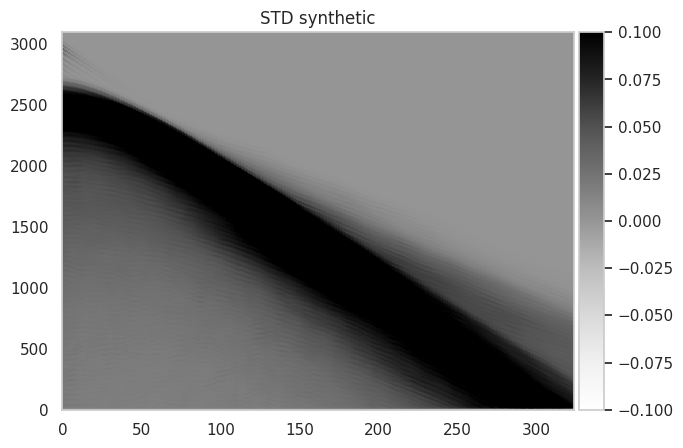

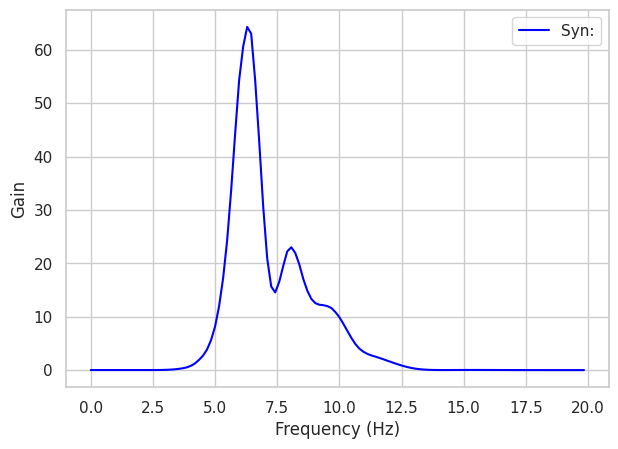

In [41]:
vis.plot_shot(src_tr_mean_ac, title='Mean synthetic', colorbar=False, vmin=-0.1, vmax=0.1)
vis.plot_shot(src_tr_std_ac, title='STD synthetic', vmin=-0.1, vmax=0.1)
vis.plot_spectra_dict([{'Syn:': src_tr_mean_ac}], dt=d.DT, fmax=20)

# Same models but elastic modeling

In [42]:
# This is where RAW elastic wavefields will be saved. If you later uncomment the modeling
# part, make sure that you are good with saving ~5 Gb of data in that location
#
# (GENERATION OF RAW DATA IS DISABLED BY DEFAULT)
root_raw_el = './pretrained_files/data/raw/syn_1024_el/' 

# Where to store the processed dataset (not yet final training)
root_dataset_syn_el = os.path.join(root_out, 'syn_1024_el')

Wavelet for elastic modeling is the same as for acoustic but flipped (there must be a bug in the source C code)

In [41]:
d_syn.SEISMO = 2
d_syn.PHYSICS = 1 # elastic modeling
d_syn.NPROCX = 2 # domain split over OX

# Re-configure sources for elastic
src_syn_el = copy.deepcopy(src_syn_ac)
src_syn_el.wavelets = wls[:, :dNT]

# Start modeling elastic data

-----
**Unomment below to run HEAVY forward modeling**

In [42]:
# if ld.is_empty(root_raw_el):
#     num_simultaneous_runs = 8
#     # NCORES = NRUNS * (NSRC * NPROCX * NPROCY) = 8 * (3 * 2) = 48. Brackets outlune nproc for every run
#     print('Start parallel pool for modeling...', end='')
#     model_ids = [i for i in range(nmodels)]
#     t1 = time.time()
#     with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
#         tmp = pool.starmap(_run_model, zip(model_ids, other_models, 
#                                            itertools.repeat(dx), 
#                                            itertools.repeat(root_raw_el),
#                                            itertools.repeat(src_syn_el),
#                                            itertools.repeat('mpirun -np 6')))
#     print(f'OK, {time.time() - t1} sec')
# else:
#     print(f'Raw elastic data is already in {root_raw_el}')

In [43]:
_path_syn_dataset_el = os.path.join(root_dataset_syn_el, 'train/raw/')
os.makedirs(_path_syn_dataset_el, exist_ok=True)
print(_path_syn_dataset_el)

./pretrained_files/data/syn_1024_el/train/raw/


## Process raw elastic data

In [44]:
par_split_el = copy.deepcopy(par_split)
par_split_el['dir_dataset'] = root_dataset_syn_el
par_split_el['dir_syn'] = root_raw_el

if ld.is_empty(_path_syn_dataset_el):
    maker = datasetmaker.DatasetMaker(par_split_el, verbose=1)
    maker.run()
print(f'Check syn dataset in {_path_syn_dataset_el}')

Check syn dataset in ./pretrained_files/data/syn_1024_el/train/raw/


Save a copy of random models to the location of elastic dataset as well

In [45]:
path_save_rand_models_el = os.path.join(root_dataset_syn_el, 'rand_models.npy')
if not os.path.exists(path_save_rand_models_el):
    os.makedirs(root_dataset_syn_el, exist_ok=True)
    print(f'Save random models to {path_save_rand_models_el}')
    np.save(path_save_rand_models_el, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))
else:
    print(f'Models are already in {path_save_rand_models_el}')

Models are already in ./pretrained_files/data/syn_1024_el/rand_models.npy


In [46]:
print(_path_syn_dataset_el)
fnames_el = ld.parse_files(_path_syn_dataset_el, '*.hh', verbose=0)
loader_src_tr_el = ld.Loader(fnames_el, par_loader)

print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset_el}\n')
dat = loader_src_tr_el.__getitem__(index)
print(f'File name: {dat[1]}\nValue: {valinfo(dat[0])}')

./pretrained_files/data/syn_1024_el/train/raw/
Init loader for:
	syn:	./pretrained_files/data/syn_1024_el/train/raw/

File name: ./pretrained_files/data/syn_1024_el/train/raw/model_1_seis_p.shot2.hh
Value: ((324, 3100), -0.7314831, 1.0)


### Statistics

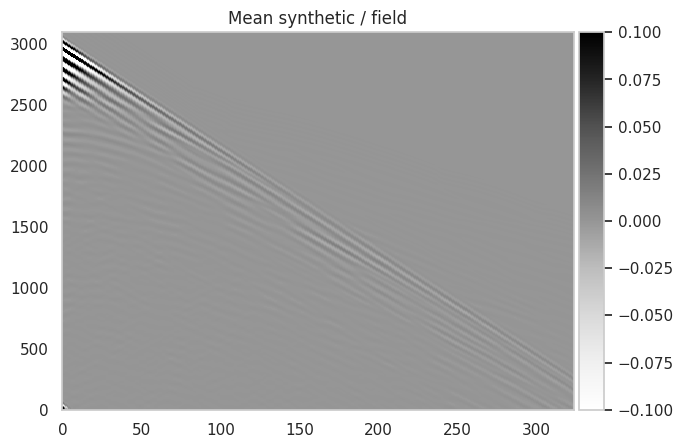

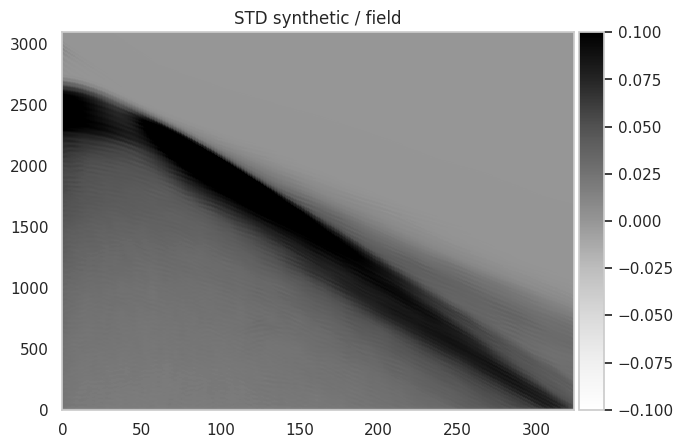

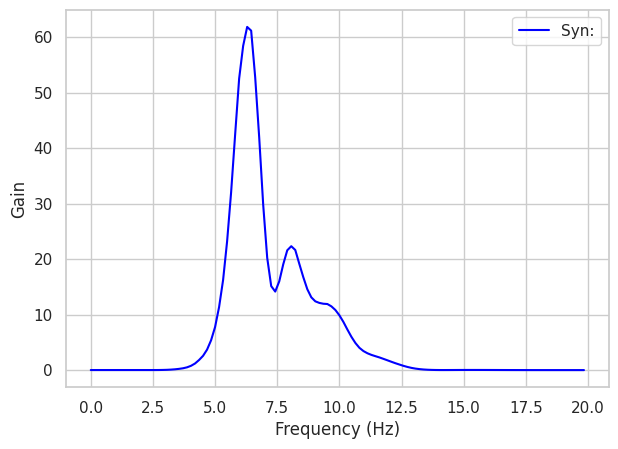

In [47]:
path_src_tr_mean = os.path.join(root_dataset_syn_el, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_el, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean_el, src_tr_std_el = get_loader_stats(loader_src_tr_el, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean_el)
    np.save(path_src_tr_std, src_tr_std_el)
else:
    src_tr_mean_el = np.load(path_src_tr_mean)
    src_tr_std_el = np.load(path_src_tr_std)

vis.plot_shot(src_tr_mean_el, title='Mean synthetic / field', colorbar=True, vmin=-0.1, vmax=0.1)
vis.plot_shot(src_tr_std_el, title='STD synthetic / field', vmin=-0.1, vmax=0.1)
vis.plot_spectra_dict([{'Syn:': src_tr_mean_el}], dt=d.DT, fmax=20)

# Match successful shots from acoustic and elastic
Acoustic modeling is prone to numerical instabilities, for some reason. For fair comparison we have to filter out unsuccessful shots first. 

This is a legacy part since I fixed the issue with acoustic modeling and now the number of shots between acoustic and elastic dataset always matches but still it is a really interesting comparison

In [48]:
selected_fnames_ac = []
for i in range(len(loader_src_tr_ac)):
    dat_ac, fname_ac = loader_src_tr_ac.__getitem__(i)
    if np.mean(np.abs(dat_ac)) > 1e-3:
        selected_fnames_ac.append(fname_ac)
print(f'Filter out failed acoustic shots: {len(loader_src_tr_ac)} --> {len(selected_fnames_ac)}')

Filter out failed acoustic shots: 2765 --> 2765


In [49]:
print(f'Num acoustic files:\t{len(selected_fnames_ac)}\nNum elastic files:\t{len(fnames_el)}')
subset_ac = set([os.path.split(f)[-1] for f in selected_fnames_ac])
subset_el = set([os.path.split(f)[-1] for f in fnames_el])
print(f'Num unique acoustic files:\t{len(subset_ac)}\nNum unique elastic files:\t{len(subset_el)}')

flag_same_num_files = True if len(subset_ac) == len(subset_el) else False
print(f'\nSame number of files in acoustic and elastic: {flag_same_num_files}')

Num acoustic files:	2765
Num elastic files:	2765
Num unique acoustic files:	2765
Num unique elastic files:	2765

Same number of files in acoustic and elastic: True


In [50]:
common_files = list(subset_ac & subset_el)
print(f'Number of commonly successful files: {len(common_files)}')

sorted_fnames_ac = [os.path.join(os.path.split(selected_fnames_ac[0])[0], f) for f in common_files]
sorted_fnames_el = [os.path.join(os.path.split(fnames_el[0])[0], f) for f in common_files]

Number of commonly successful files: 2494


# Acousic VS Elastic in a random subsurface model

In [51]:
loader_src_tr_ac = ld.Loader(sorted_fnames_ac, par_loader)
loader_src_tr_el = ld.Loader(sorted_fnames_el, par_loader)

jjloader_tr = ld.JointLoader(loader_src_tr_ac, loader_src_tr_el)

## 10 Hz and 3 Hz comparison

Temporal sampling: 0.002
Model id: 406, shot id: 3
./pretrained_files/data/syn_1024_ac/train/raw/model_406_seis_p.shot3.hh ((324, 3100), -0.7314828, 1.0) 0.037330635
./pretrained_files/data/syn_1024_el/train/raw/model_406_seis_p.shot3.hh ((324, 3100), -0.7314828, 1.0) 0.025630662


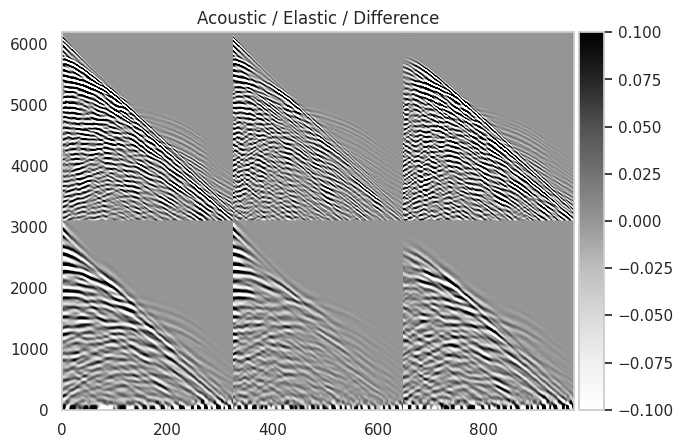

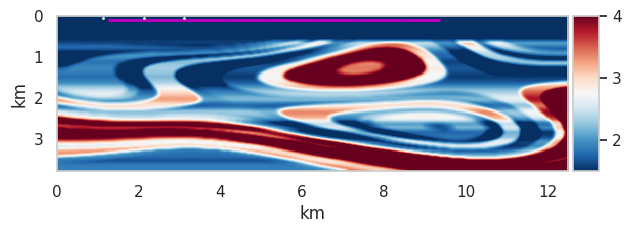

In [52]:
index += 1
dat_el = jjloader_tr.__getitem__(index)

par_bp = {'fs': 1/(d_syn.DT * d_syn.NDT), 'fhi': 3, 'btype': 'low'}
print(f'Temporal sampling: {d_syn.DT * d_syn.NDT}')

dat_src_ac = dat_el[0]
dat_src_el = dat_el[2]

model_id = int((os.path.split(dat_el[1])[-1]).split('_')[1])
shot_id = int((os.path.split(dat_el[1])[-1]).split('.')[-2].replace('shot', ''))
print(f'Model id: {model_id}, shot id: {shot_id}')

print(dat_el[1], valinfo(dat_src_ac), np.mean(np.abs(dat_src_ac)))
print(dat_el[3], valinfo(dat_src_el), np.mean(np.abs(dat_src_el)))

vis.plot_shot(np.concatenate([ld.divmax(np.concatenate([dat_src_ac, dat_src_el, dat_src_el - dat_src_ac], 0)),
                             ld.divmax(np.concatenate([ld.bandpass(dat_src_ac, **par_bp),
                                                       ld.bandpass(dat_src_el, **par_bp),
                                                       ld.bandpass(dat_src_el - dat_src_ac, **par_bp)], 0))], 1),
             pclip=0.1,
             axis='off',
             title='Acoustic / Elastic / Difference')
vis.plot_acquisition(other_models[model_id], dx, src_syn_ac, rec_syn)
# print(f'Syn:\t{dat_src.shape}\nField:\t{dat_src_el.shape}')

# Mean and STD of Acoustic and Elastic

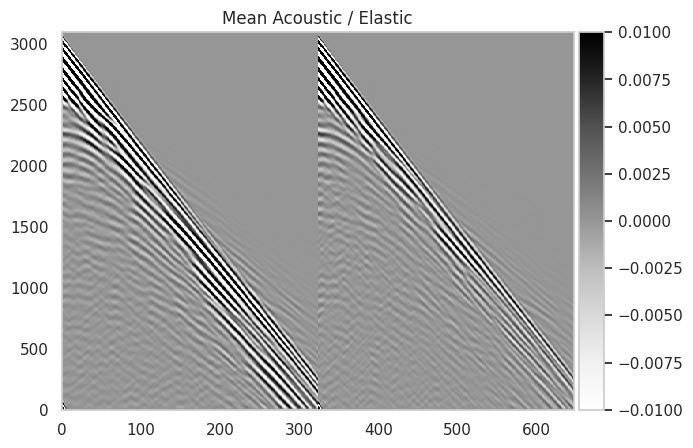

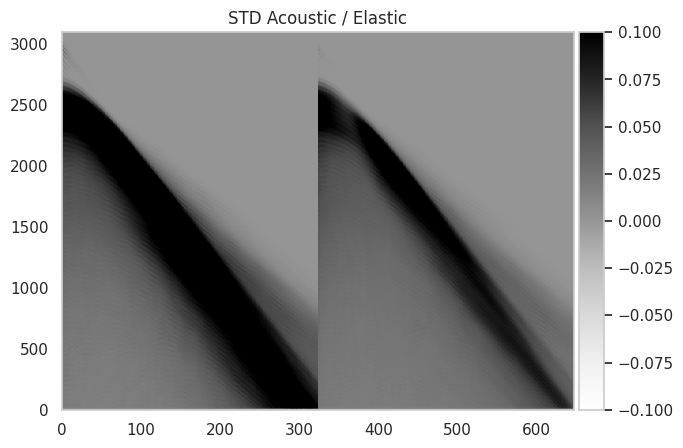

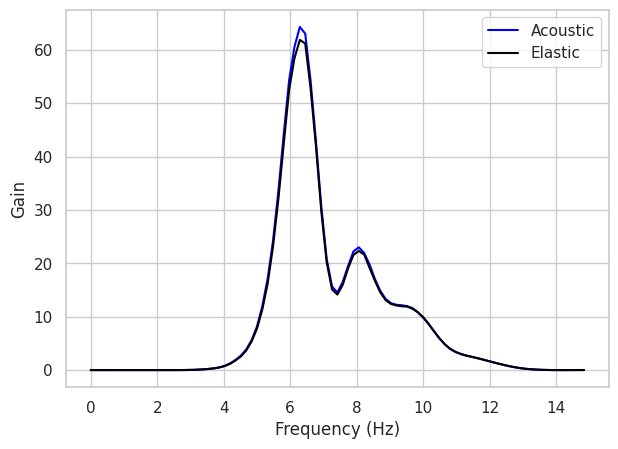

In [53]:
# Mean
vis.plot_shot(np.concatenate([src_tr_mean_ac, src_tr_mean_el], 0), 
              title='Mean Acoustic / Elastic', colorbar=True, vmin=-0.01, vmax=0.01)

# STD
vis.plot_shot(np.concatenate([src_tr_std_ac, src_tr_std_el], 0), title='STD Acoustic / Elastic', vmin=-0.1, vmax=0.1)

# Spectrum
dictlist = [{'data': src_tr_mean_ac, 'line': 'b', 'label': 'Acoustic'}, 
            {'data': src_tr_mean_el, 'line': 'k', 'label': 'Elastic'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)